# Michaelis-Menten Model Calibration Notebook

Based on PTemPest example written in Matlab [here](https://github.com/RuleWorld/ptempest/tree/master/examples/michment)

## Overview

This system describes the 1) reversible binding of an enzyme to substrate and 2) production of substrate product which is defined in the following scheme:  
$$E + S \rightleftharpoons^{k_f}_{k_r} ES \longrightarrow^{k_{cat}} E + P$$  

Assuming total enzyme concentration is significantly smaller than substrate concentration (i.e., $[E]_T \ll [S]$), the rate is defined as:  
$$\frac{d[P]}{dt} = \frac{k_{cat}[E]_T[S]}{K_M + [S]}$$
where $K_M = \frac{k_{cat} + k_r}{k_f}$

## Model Calibration

The following notebook calibrates the Michaelis-Menten model system using synthetically generated data with 1% Gaussian error. 

Here, we test the following inference methods:
1. Metropolis-Hastings (`pyPESTO`)
2. Parallel-Tempering MCMC (`pyPESTO`)
3. Nested Sampling (`dynesty`)
4. Sequential Monte Carlo (`pocoMC`)
5. Preconditioned Monte Carlo (`pocoMC`)

### Load relevant packages

In [25]:
import sys 
sys.path.append("../pocomc/")

import os
import time
import pickle
import roadrunner as rr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import qmc
from multiprocessing import Pool

import pocomc as pc

SEED = 1
np.random.seed(seed=SEED)

n_cpus = os.cpu_count() 
print('This machine has {} CPUs'.format(n_cpus))

This machine has 10 CPUs


### Defining the `Model` class

The model class has the following attributes:
1. `x_n` : `int`<br>
    Number of species in the model
2. `fit_x0` : `bool`<br>
    Whether the initial conditions are to be estimated and are therefore included in `theta` args.
3. `fit_sigma` : `bool`<br>
   Whether to estimate the standard deviation of the experimental data which is also used in the `log_likelihood()` function
4. `x0` : `list[float], optional`<br>
   The initial conditions of model species
5. `ODE_params_n` : `int`<br>
   Number of parameters used in ODEs/SBML model
6. `theta_n` : `int`<br>
    Number of parameters to be fit. This includes ALL parameters to be estimated which MAY include initial conditions and the standard deviation of the model species.<br> The order of the model parameters in this list is assumed to be as follows:<br>
    1. ODE equation parameters
    2. Initial conditions (denoted $x_\#$, **optional**)
    3. Species standard deviations (denoted $\sigma_\#$)
7. `theta_true` : `list[float]` of shape `(theta_n)`<br>
    True theta values of the model system. 
8. `lower_bnds` : `list[float]` of shape `(theta_n)`<br>
    Lower bounds of parameter values 
9.  `upper_bnds` : `list[float]` of shape `(theta_n)`<br>
    Upper bounds of parameter values 
10. `ts` : `list[float]`<br> 
    Experimental data times 
11. `data` : `list[float]` of shape `(len(ts), x_n)`<br> 
    Experimental data used for model calibration
12. `librr_model` : `<class 'roadrunner.roadrunner.RoadRunner'>`<br>
    `libroadrunner` model object loaded from SBML file of the model
13. `librr_theta` : `list[str]`<br>
    The names of the ODE parameters as specified in the SBML file. These are used to actually change the parameters during calibration so they _must_ match the parameter names in the SBML file.
14. `librr_species` : `list[str]`<br>
    Names of the species ID defined in the SBML file. Note: you must use the SBML file `species` ID and not the name (eg. `S1` for the substrate and `S2` for the enzyme). The length of this list must be equal to `x_n`
15. `librr_labels` : `list[str]`<br>
    Labels used for plotting purposes of all the model species. This _could_ be the same as the `species` name from the SBML file but that is up to the user. The length of this list must be equal to `x_n`
16. `observable_idxs` : `list[int]`<br> 
    The indices of `librr_species` that are used to compare fit to experimental data. The length of `observable_idxs` _must_ be $\leq$ `x_n`

#### `Model` class assumptions

The species order of the following is assumed to be the same:
1. `librr_labels`
2. `librr_species`
3. `x0`
4. `data`

The parameter order of the following is assumed to be the same:
1. `theta_true`
2. `lower_bnds`
3. `upper_bnds`
4. `librr_theta` (only includes ODE parameters)

The prior is assumed to be uniform given lower and upper bounds. Note in the Michaelis-Menten BNGL model, we are estimating the log-transformed rate constants (eg log_k1) and thus assuming the prior is _log-uniform_.

As stated in [Ballnus et al., 2017](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-017-0433-1):

> The likelihood of observing the data $\mathcal{D}$ given the parameters $\theta$ is: <br>
> $$P(\mathcal{D}|\theta) = \prod_{i=1}^{n_y} \prod_{k=1}^{n_t} \frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{\left(-\frac{( \tilde{y}_{ik} -  y_i(t_k))^2}{2\sigma_i^2}\right)}$$
> where $n_y$ is the number of species/observables in the data and $n_t$ is the number of time points. 
<br><br>


Thus the log likelihood is defined as follows:
<br>

$$\mathcal{LL} = \sum_{i=1}^{n_y} \sum_{k=1}^{n_t} -\frac{1}{2} \log{\left(2\pi\sigma_i^2\right) - \frac{( \tilde{y}_{ik} -  y_i(t_k))^2}{2\sigma_i^2}}$$



In [26]:
class Model:
    def __init__(self, opts): #initial settings
        for key in opts: #loops for all labels in the list 'key'
            setattr(self, key, opts[key]) #creates a dictionary where 'key' are the list of labels & 'ops[key]' are the values
        # Default model output to times and experimental observables
        self.observables= list(self.data.columns)[1:]
        self.defaultOutput= ['time'] + self.observables
        self.n_params= len(self.params)
        self.n_obs= len(self.observables)

    def __call__(self, theta_new):
        theta_new = theta_new
        res = self.log_likelihood(theta_new)
        return res
    
    def run(self, params=None, x0=None, times=None, output=None):
        rr = self.rr
        rr.reset()
        rr.integrator.absolute_tolerance = 5e-10
        rr.integrator.relative_tolerance = 1e-8

        # Use timepoints of data as default times at which to get sim output
        if params is None:
            params= self.p_true  
        if x0 is None:
            x0= self.x0
        if times is None:
            times= self.data['time'].values
        # Set default output are the column names of the data
        if output is None:
            output= self.defaultOutput

        # Set initial concentration values
        for spec_name, val in zip(self.species, x0):
            init_species_string = f"init([{spec_name}])"
            rr[init_species_string] = float(val)

        # Set parameter values
        for name, value in zip(self.params, params):
            rr[name] = float(value)
        rr.reset() # force update of parameter expression (POSSIBLY NOT NEEDED)

        #print([rr[name] for name in self.params])
        # Run trajectories
        traj = rr.simulate(times=times,selections=output)
        return traj   
    
    def log_prior(self, theta_new): 
        bools = [(low <= i <= high) for i,low,high in zip(theta_new, self.lower_bnds, self.upper_bnds)] #if generated values are within bounds
        all_in_range = np.all(bools) #if all values are true, then output is true
        if all_in_range: 
            return 0.0 
        return -np.inf #if even one parameter out of bounds, it's false, and returns -infinity

    def log_likelihood(self, theta_new): #how good is this candidate parameter fitting my data (maximize it)
        params = theta_new[:self.n_params] 
        if self.fit_x0: 
            x0 = theta_new[self.n_params:(self.n_params + len(self.x_0))] #sets x0 to 'theta_true' x0 values
        else:
            x0 = self.x0
        y = self.run(params=params, x0=x0)[:,1:] #sets y to the y results of solving ODE

        if self.fit_sigma:
            sigma = theta_new[-len(self.observables):] #observable index related to sigma
        else:
            sigma = [1] * len(self.observables) #makes all sigmas default to 1
   
        # Data for observables
        # if (self.n_obs > 1):
        #     obs = self.data.values[:,1:] #sets data
        # else:
        obs = self.data.values[:,1:] #sets data

        # Calculate likelihood
        term1 = -0.5 * np.log(2*np.pi*np.square(sigma))
        term2 = np.square(np.subtract(y, obs)) / (2*np.square(sigma))
        logLH = np.sum(term1 - term2)
        return(logLH)
        #return np.array(logLH)

### Defining the dictionary used to create the Michaelis-Menten problem in the `Model` class

In [27]:
# Michaelis-Menten Model Options
mod_opts = {} #creates a dictionary


# load data for model
mod_df = pd.read_csv('mm_data.csv', header=0, delimiter=",") #reads in data file
mod_opts['data'] = mod_df
# Load in SBML model using libroadrunner
sbml_file = "mm_sbml.xml"
mod_opts['rr'] = rr.RoadRunner(sbml_file)
mod_opts['params'] = ["log_k1", "log_k2", "log_k3"]
mod_opts["species"] = ["S1", "S2", "S3", "S4"]
mod_opts['x0'] = [600,6,0,0] # initial conditions (if given)

# ! TO DO: we currently assume it fit_x0, then ALL species initial conditions are fit
mod_opts['fit_x0'] = False # fit initial conditions?
mod_opts['fit_sigma'] = False #fit sigma?
mod_opts['p_true'] = [-2.77, -1.0, -2.0] #guess param values(in log)
mod_opts['lower_bnds'] = [-3.0,-1.0,-3.0] #lower bounds(in log)
mod_opts['upper_bnds'] = [1.0,3.0,3.0] #upper bounds(in log)

model = Model(mod_opts)

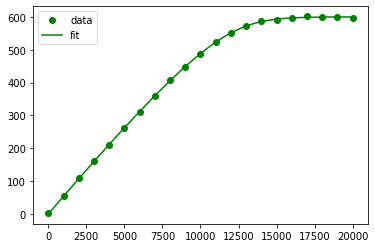

In [20]:
traj= model.run(params=model.p_true,output=list(model.data.columns))
plt.plot(model.data['time'].values,model.data['P'].values,'go',label='data')
plt.plot(traj[:,0],traj[:,1],'g-',label='fit')
_=plt.legend()

The discrepancy of the sampling (i.e., sample quality): 0.0001


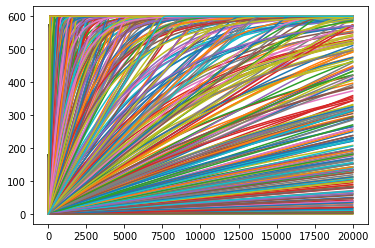

In [5]:
# Test integration
sampler = qmc.LatinHypercube(d=model.n_params, seed=SEED)
sample = sampler.random(n=1000) 
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=model.lower_bnds, u_bounds=model.upper_bnds)
times= np.linspace(0,20000,201)
for p in (prior_samples):
    traj = model.run(params=p,times=times)
    plt.plot(traj[:,0], traj[:,1])
    


Text(0.5, 0, 'Sum of squares')

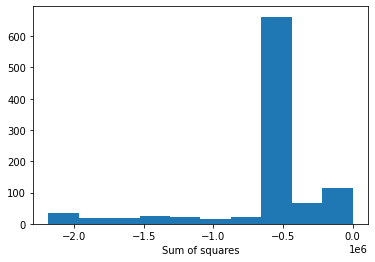

In [6]:
# Distribution of likelihood
samples= np.array([model.log_likelihood(p) for p in (prior_samples)])
# print(max(samples))
# print(model.log_likelihood(model.p_true))
plt.hist(samples)
plt.xlabel('Sum of squares')

In [35]:
model.log_likelihood(model.p_true)

-44.30886075287601

## Model Calibration

### Initialize samples

In [31]:
n_particles = 100

# Initialise particles' positions using samples from the prior 
sampler = qmc.LatinHypercube(d=model.n_params, seed=SEED)
sample = sampler.random(n=n_particles) 
print("The discrepancy of the sampling (i.e., sample quality): %.4f"%qmc.discrepancy(sample)) #discrepancy is distance between cont. uniform distr. on hypercube & discr. uniform distr. on n distinct sample points
prior_samples = qmc.scale(sample, l_bounds=model.lower_bnds, u_bounds=model.upper_bnds)
print(prior_samples.shape)

The discrepancy of the sampling (i.e., sample quality): 0.0006
(100, 3)


### Run `pocoMC`

In [32]:
t0 = time.time() #stores current time, date, year, etc. in one float
# with Pool(n_cpus) as pool: #sets up code to run over my n number of cpus on laptop
    
sampler = pc.Sampler(n_particles = n_particles,
                n_dim = model.n_params,
                log_likelihood = model.log_likelihood,
                log_prior = model.log_prior,
                bounds = np.array(list(zip(model.lower_bnds, model.upper_bnds))),
                random_state=SEED,
                vectorize_likelihood=False,
                vectorize_prior=False,
                infer_vectorization=False
            ) #stores all relevant info from # of parameters being fit (ndim) to the actual results

sampler.run(prior_samples = prior_samples) #starts with prior sample definied in latin hypercube sampling, and runs it
result = sampler.results #results of sampler.run on prior_samples

with open('tester01_result.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(result, f, protocol=pickle.HIGHEST_PROTOCOL) #saves result object (dictionary) to pickle file

# we need to remove the librr simulator from the class in order to successfully save and load the class from a pkl file. 
#del model.rr
with open('tester01_mod.pkl', 'wb') as f: #open that file if exists, if not make that file
    pickle.dump(model.__dict__, f, protocol=pickle.HIGHEST_PROTOCOL) #saves model dictionary in pickle file

t1 = time.time() #time after running this section
seconds = t1-t0 #difference in start and stop time

elapsed = time.strftime("%H:%M:%S", time.gmtime(seconds)) #converts float to a time quantity we use
print('\nElapsed time: ', elapsed) #printing time it took for code to run

Iter: 13it [00:31,  3.22s/it, beta=3.16e-5, calls=5500, ESS=0.949, logZ=-3.42, accept=0.289, N=5, scale=0.518, corr=0.82] 

KeyboardInterrupt: 

In [271]:
pc.plotting.trace(result, labels=model.params);

Error in callback <function flush_figures at 0x7fc7185893a0> (for post_execute):


KeyboardInterrupt: 

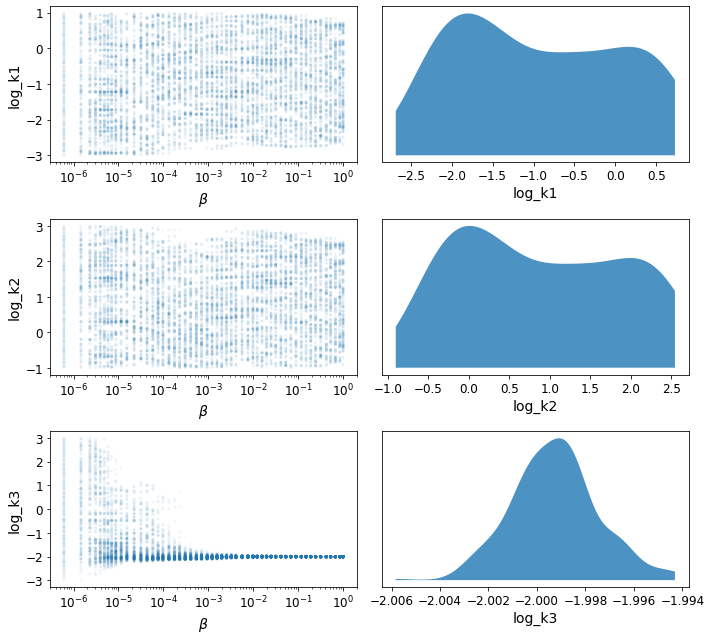

In [253]:
with open("tester01_result.pkl", "rb") as f:
    result = pickle.load(f)
pc.plotting.trace(result, labels=model.params);

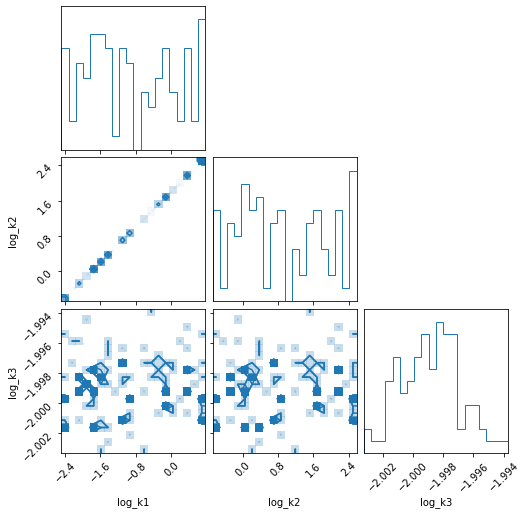

In [254]:
pc.plotting.corner(result, labels=model.params);